In [1]:
# 创建于2021/03/31
# 修改于2021/10/31
# Python: 3.7.4
# Tensorflow: 2.4.1

import os
import io
import numpy as np
import math
import _pickle as pickle
import tensorflow as tf
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from easydl import clear_output

# order-全局参数-用来表示激活函数展开的阶数，从-order到+order对称展开
global order
# cycle-全局参数-用来表示激活函数展开截断的周期
global cycle
# Bk-全局参数-列表形式记录激活函数展开三角级数中sin的系数
global Bk
# Dk-全局参数-列表形式记录激活函数展开三角级数中cos的系数
global Dk
# Ck-全局参数-列表形式记录激活函数展开Fourier级数中复指数函数的系数
global Ck

order = 100
cycle = 6

# 导入数据集
###############################################################
mnist = open('./mnist.pkl','rb')
data = pickle.load(mnist,encoding = 'bytes')
image_train, label_train = data[0]
image_test, label_test = data[2]
[num_train, image_shape] = np.shape(image_train)
del data, mnist


[easydl] tensorflow not available!


In [2]:
# 设置隐藏层节点数，不宜过小，否则参数范围会增加，导致激活函数展开后的精度急剧下降
nodes = 256

# 构建与训练网络
###############################################################
model = tf.keras.models.Sequential()
# 输入层以全部像素点展开作为输入
model.add(tf.keras.layers.InputLayer(input_shape = image_shape))
# 设置隐藏层，该层受制于文章模型不考虑偏置
model.add(tf.keras.layers.Dense(units = nodes, activation = 'relu', use_bias = False))
# 设置输出层，MNIST-10分类
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))
# 利用SGD而不用其他自适应学习率算法是考虑到如果学习率在后期很低，则在网络最优点附近精度对权重变化的敏感度可能会很高
# 学习率最好控制在激活函数展开精度可控的范围内，其中SGD默认学习率为0.01，损失函数配合softmax选择熵函数，输出指标选择精度
model.compile(optimizer = 'SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# 训练模型，小批的大小影响不大，批次只要网络收敛即可
model.fit(x = image_train, y = label_train, batch_size = 500, epochs = 30)
# 清屏训练信息
clear_output()
# 查看泛化精度，verbose控制只显示最终结果
model.evaluate(x = image_test, y = label_test, verbose = 2)


313/313 - 0s - loss: 0.3038 - accuracy: 0.9187


[0.30380329489707947, 0.9186999797821045]

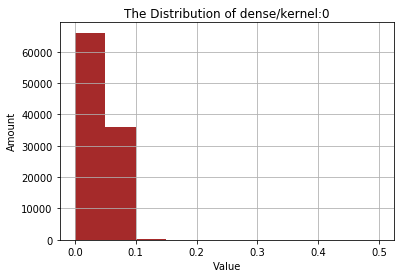

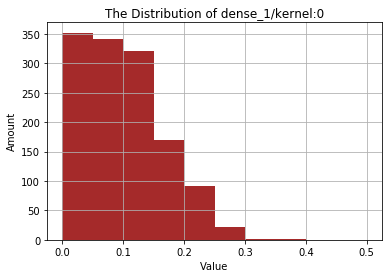

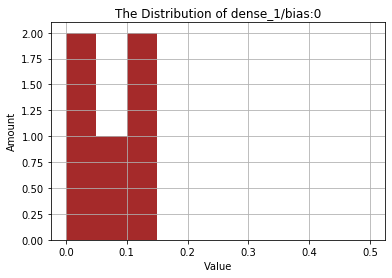

In [3]:
# 统计参数分布
###############################################################
name = ['DistributionWXY.tiff', 'DistributionVYZ.tiff', 'DistributionBias.tiff']
bx = 0
# 参数显示范围设计为0到1.1，间隔0.05
x = [tick / 20 for tick in range(0, 11)]
# 显示神经网络中所有参数的大小分布直方图
# 注意所有参数大小均应该控制在截断周期以内，否则需要调大周期或增加节点数
for para in model.trainable_variables:
    para_flat = np.ravel(para.numpy())
    plt.figure()
    plt.hist(para_flat, x, color = "brown")
    plt.grid()
    plt.xlabel('Value')
    plt.ylabel('Amount')
    plt.title('The Distribution of %s'%para.name)
    png = io.BytesIO()
    plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
    tiff = Image.open(png)
    tiff.save(name[bx])
    bx += 1
    png.close()
del x, para_flat


In [4]:
# 计算ReLU激活函数的三角级数系数
###############################################################
# 计算公式是通过手算得到的，这里曾经期望调用tensorflow的张量运算，将运算以图的形式加入网络算法图以达到加速的效果
# 但最终还是以全局变量声明的形式保存系数，因为这部分会占用较高的计算资源
def Coefficient():
    # 常项系数单独赋值
    B0 = [cycle / 16]
    D0 = [0.0]
    # 提前预备常用因子以加快速度，order决定了需要的张量长度
    interim = tf.constant([math.pi * k for k in range(1, order + 1)])
    # 这部分作为分母需要经常调用
    denominator = tf.math.divide(tf.math.multiply(tf.math.square(interim), 4), cycle)
    cos = tf.math.cos(interim)
    sin = tf.math.sin(interim)
    # 以张量计算形式得到其余系数
    B1 = tf.math.divide(tf.math.subtract(tf.math.add(tf.math.multiply(interim, sin), cos), 1), denominator)
    D1 = tf.math.divide(tf.math.subtract(tf.math.multiply(interim, cos), sin), denominator)
    # 组合两部分系数
    B = tf.concat([B0, B1.numpy()], 0)
    D = tf.concat([D0, D1.numpy()], 0)
    return B, D

# 计算得到三角级数系数全局变量
Bk, Dk = Coefficient()


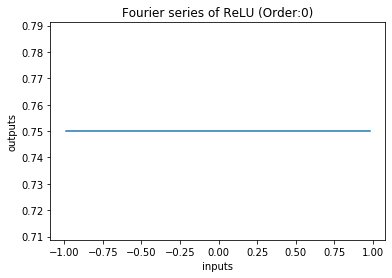

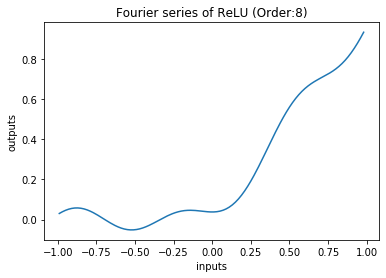

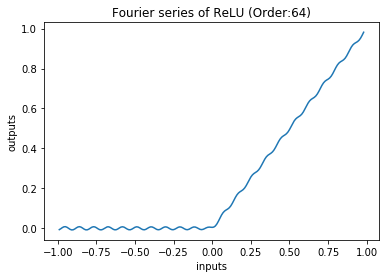

In [5]:
# 定义分部ReLU激活函数
###############################################################
def ReLU_apart(data):
    # 此前计算的三角级数系数阶数较高，考虑到此后运行可能不需要这么高阶次因此首先截断
    # 分解ReLU的方法始终是Fourier级数，用三角级数的等价关系是为了避免复数计算
    B = Bk[0: order + 1]
    D = Dk[0: order + 1]
    # 提前预备常用因子以加快速度
    interim = tf.math.divide(tf.math.multiply(tf.math.multiply(math.pi, data), 2), cycle)
    # 初始化结果张量
    result = tf.math.subtract(data, data)
    for cx in range(0, order + 1):
        # 计算每项弧度
        ang = tf.math.multiply(interim, cx)
        # 依三角级数公式叠加每一项
        result += tf.math.multiply(tf.math.subtract(tf.math.multiply(B[cx], tf.math.cos(ang)), tf.math.multiply(D[cx], tf.math.sin(ang))), 2)
    return result

# 查看级数逼近效果
# 显示-1到1
x = [tick / 100 for tick in range(-99,99)]
# 以递增阶数的形式查看逼近效果
for cx in range(0,6,2):
    order = cx * cx * cx
    y = [ReLU_apart(tick / 100).numpy() for tick in range(-99,99)]
    plt.figure()
    plt.plot(x,y)
    plt.title('Fourier series of ReLU (Order:%d)'%order)
    plt.xlabel('inputs')
    plt.ylabel('outputs')
del x, y


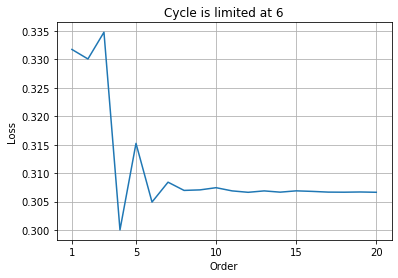

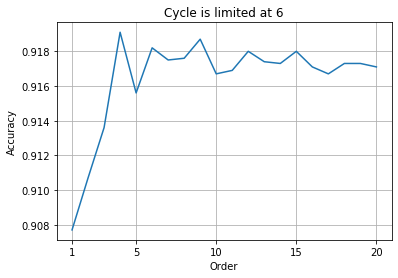

In [6]:
# 定义分部神经网络并推理
###############################################################
# 定义网络初始化参数的函数，目的是在相同结构的网络间传递网络参数
def weightshare(model, shape):
    for variable in model.trainable_variables:
        # 由于所用网络较小于是直接通过对比权重维度以确定传递哪部分参数
        if(variable.shape == shape):
            return variable.numpy()
    return

# 初始化损失与精度列表
loss = np.zeros(20)
accu = np.zeros(20)
# 循环设定阶次取值，查看阶次截断对网络性能的影响
for order in range(1, 21):
    # 构建新网络apart，其结构与此前训练的网络完全一致
    model_apart = tf.keras.models.Sequential()
    model_apart.add(tf.keras.layers.InputLayer(input_shape = image_shape))
    # 调整激活函数为对应阶数的分部ReLU函数，权值和前一个网络保持一致
    model_apart.add(tf.keras.layers.Dense(units = nodes, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weightshare(model, [int(image_shape), nodes]))))
    # 权值和偏置保持和前一个网络一样，其他也不变
    model_apart.add(tf.keras.layers.Dense(units = 10, activation = 'softmax',  kernel_initializer = tf.constant_initializer(weightshare(model, [nodes, 10])), bias_initializer = tf.constant_initializer(weightshare(model, [10, ]))))
    model_apart.compile(optimizer = 'SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    # 不经过训练直接在测试集上评估精度
    loss[order - 1], accu[order - 1] = model_apart.evaluate(x = image_test, y = label_test, verbose = 0)
    del model_apart

# 绘制损失对阶次变化曲线
plt.figure()
plt.plot([tick for tick in range(1, 21)], loss)
plt.xlabel('Order')
plt.ylabel('Loss')
plt.title('Cycle is limited at 6')
plt.xticks([1, 5, 10, 15, 20])
plt.grid()
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MNIST-ORDER-LOSS.tiff')
png.close()

# 绘制精度对阶次变化曲线
plt.figure()
plt.plot([tick for tick in range(1, 21)], accu)
plt.xlabel('Order')
plt.ylabel('Accuracy')
plt.title('Cycle is limited at 6')
plt.xticks([1, 5, 10, 15, 20])
plt.grid()
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MNIST-ORDER-ACCURACY.tiff')
png.close()


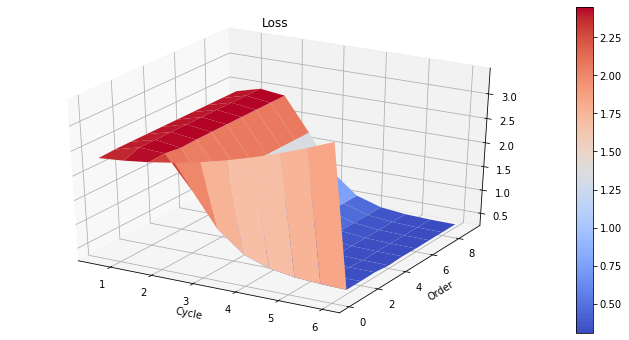

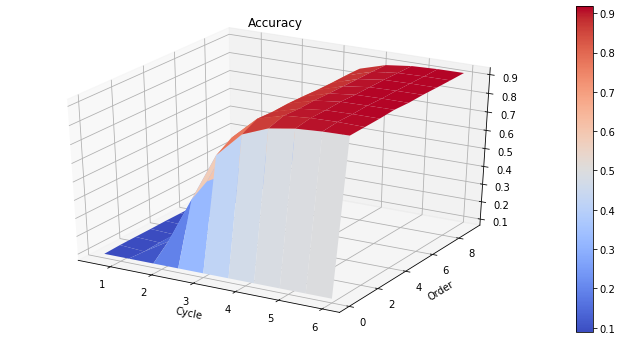

In [7]:
# 查看阶数和截断周期对网络性能的影响
###############################################################
# 两参数分别取10组值，初始化存储性能的矩阵
loss = np.zeros((10, 10))
accuracy = np.zeros((10, 10))

# 遍历10个阶次取值，取值1到10
for cx in range(0, 10):
    order = cx
    # 遍历10个周期取值，间隔0.6，取值0.6到6
    for ax in range(1, 11):
        cycle = 0.6 * ax
        # 针对阶次和周期重新计算三角级数系数
        Bk, Dk = Coefficient()
        # 构建网络查看性能，该网络和此前的apart网络构建方法完全一致
        model_apart = tf.keras.models.Sequential()
        model_apart.add(tf.keras.layers.InputLayer(input_shape = image_shape))
        model_apart.add(tf.keras.layers.Dense(units = nodes, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weightshare(model, [int(image_shape), nodes]))))
        model_apart.add(tf.keras.layers.Dense(units = 10, activation = 'softmax',  kernel_initializer = tf.constant_initializer(weightshare(model, [nodes, 10])), bias_initializer = tf.constant_initializer(weightshare(model, [10, ]))))
        model_apart.compile(optimizer = 'SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        # 输出中间信息以监视进程
        print('order: %d, cycle: %f'%(order, cycle))
        loss[cx, ax - 1], accuracy[cx, ax - 1] = model_apart.evaluate(x = image_test, y = label_test, verbose = 2)
        # 删除网络以便下一轮重新构建
        del model_apart

# 清理中间过程信息
clear_output()
# 建立画图所需要的两个坐标轴
x_grid, y_grid = np.meshgrid([ax * 0.6 for ax in range(1,11)], [cx for cx in range(0,10)])

# 绘制损失平面
fig = plt.figure(figsize = (12, 6))
loss_3d = plt.axes(projection = '3d')
surface = loss_3d.plot_surface(x_grid, y_grid, loss, cmap = plt.cm.coolwarm)
fig.colorbar(surface)
plt.title('Loss')
loss_3d.set_xlabel('Cycle')
loss_3d.set_ylabel('Order')
# loss_3d.view_init(elev = 60, azim = -120)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MNIST-ORDER-CYCLE-LOSS.tiff')
png.close()

# 绘制精度平面
fig = plt.figure(figsize = (12, 6))
accuracy_3d = plt.axes(projection = '3d')
surface = accuracy_3d.plot_surface(x_grid, y_grid, accuracy, cmap = plt.cm.coolwarm)
fig.colorbar(surface)
plt.title('Accuracy')
accuracy_3d.set_xlabel('Cycle')
accuracy_3d.set_ylabel('Order')
# accuracy_3d.view_init(elev = 60, azim = -120)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MNIST-ORDER-CYCLE-ACCURACY.tiff')
png.close()

del x_grid, y_grid, loss_3d, accuracy_3d, loss, accuracy
del image_train, label_train, image_test, label_test


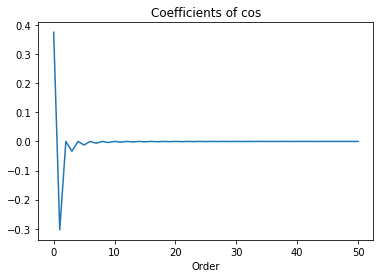

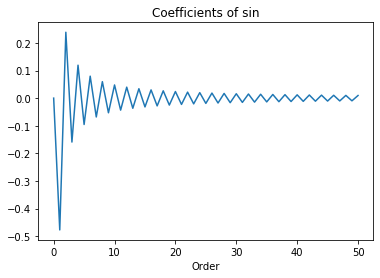

In [8]:
# 查看级数系数取值随order的趋势图
###############################################################
order = 50
cycle = 6
Bk, Dk = Coefficient()

# 绘制全部系数依阶数排列
# 可见ReLU的级数系数重点集中于前10阶，后面系数逐渐趋于零，如不明显可以放大阶数查看
x = [tick for tick in range(0, order + 1)]

fig = plt.figure()
plt.plot(x, Bk.numpy())
plt.title('Coefficients of cos')
plt.xlabel('Order')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('CoefficientsCOS.tiff')
png.close()

fig = plt.figure()
plt.plot(x, Dk.numpy())
plt.title('Coefficients of sin')
plt.xlabel('Order')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('CoefficientsSIN.tiff')
png.close()

del x


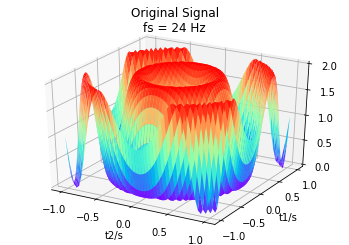

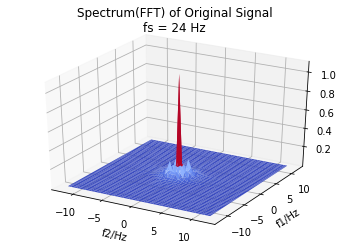

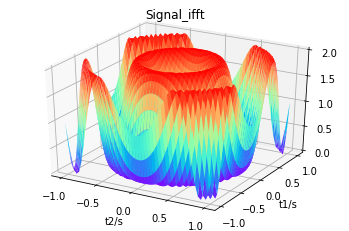

In [9]:
# 生成模拟映射关系的信号
###############################################################
# 重新规定阶数和阶段周期，以之前得到的结果取order=10；cycle=6即可满足精度要求
order = 10
cycle = 6
# 重新计算三角级数系数
Bk, Dk = Coefficient()

# 这里以二维信号为例，设置两个主要的频率
f1 = 1
f2 = 1
# 初始化采样率
fs = 24
# 给定测试集采样率
fs_test = 96
# 从-1到1时域采样，初始化样点数
# 样点数目不宜过小，相比激活函数展开阶数越大越精确，因为在重建频谱时是不考虑高阶系数的影响超出频谱范围的情况的
# 但在网络计算过程中，仍然存在这部分的影响，频谱范围越小这些余项的影响相对就越大，进而将严重影响网络预测结果
N = 2 * fs + 1
N_test = 2 * fs_test + 1
# 定义坐标
t = np.array([tick / fs for tick in range(-fs, fs + 1)])
f = np.array([tick / 2 for tick in range(-fs, fs + 1)])
t_test = np.array([tick / fs_test for tick in range(-fs_test, fs_test + 1)])
# 初始化二维信号矩阵
signal = np.zeros((N, N))
signal_test = np.zeros((N_test, N_test))
# 同时准备生成新数据集描述该映射关系
data = np.zeros((N * N, 2))
data_test = np.zeros((N_test * N_test, 2))
label = np.zeros(N * N)
label_test = np.zeros(N_test * N_test)

tick = 0
# 为二维信号赋值
for cx in range(N):
    for ax in range(N):
        # 映射关系
        signal[cx, ax] = math.sin(2 * math.pi * (f1 * math.pow(t[cx], 2) + f2 * math.pow(t[ax], 2))) + 1
        # 赋值网络输入数据和期望输出数据为该函数关系
        data[tick, 0], data[tick, 1] = t[cx], t[ax]
        label[tick] = signal[cx, ax]
        tick += 1
tick = 0
# 为二维测试信号赋值
for cx in range(N_test):
    for ax in range(N_test):
        # 映射关系
        signal_test[cx, ax] = math.sin(2 * math.pi * (f1 * math.pow(t_test[cx], 2) + f2 * math.pow(t_test[ax], 2))) + 1
        # 赋值网络输入数据和期望输出数据为该函数关系
        data_test[tick, 0], data_test[tick, 1] = t_test[cx], t_test[ax]
        label_test[tick] = signal_test[cx, ax]
        tick += 1

# 设定坐标轴
time = [-1, -0.5, 0, 0.5, 1]
value = [0, 0.5, 1, 1.5, 2]
x_grid, y_grid = np.meshgrid(t, t)
x_test_grid, y_test_grid = np.meshgrid(t_test, t_test)
fx_grid, fy_grid = np.meshgrid(f, f)
# 绘制二维信号图像
fig = plt.figure()
data_3d = plt.axes(projection = '3d')
surface = data_3d.plot_surface(x_grid, y_grid, signal, cmap = 'rainbow')
plt.title('Original Signal\nfs = %d Hz'%fs)
data_3d.set_xlabel('t2/s')
data_3d.set_ylabel('t1/s')
data_3d.set_xticks(time)
data_3d.set_yticks(time)
data_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Origin_fs24.tiff')
png.close()
del data_3d, t, f

# 计算得到信号频谱并绘制信号频谱图
spectrum = np.fft.fft2(signal) / math.pow(N, 2)
spectrum_shift = np.fft.fftshift(spectrum)
fig = plt.figure()
spec_3d = plt.axes(projection = '3d')
surface = spec_3d.plot_surface(fx_grid, fy_grid, abs(spectrum_shift), cmap = plt.cm.coolwarm)
plt.title('Spectrum(FFT) of Original Signal\nfs = %d Hz'%fs)
spec_3d.set_xlabel('f2/Hz')
spec_3d.set_ylabel('f1/Hz')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Origin_FFT.tiff')
png.close()
del spec_3d

# 绘制重建二维信号图像
data_rebuild_shift = np.fft.ifftshift(spectrum_shift * math.pow(N, 2))
data_rebuild = np.abs(np.fft.ifft2(data_rebuild_shift))
fig = plt.figure()
data_rebuild_3d = plt.axes(projection = '3d')
surface = data_rebuild_3d.plot_surface(x_grid, y_grid, data_rebuild, cmap = 'rainbow')
plt.title('Signal_ifft')
data_rebuild_3d.set_xlabel('t2/s')
data_rebuild_3d.set_ylabel('t1/s')
data_rebuild_3d.set_xticks(time)
data_rebuild_3d.set_yticks(time)
data_rebuild_3d.set_zticks(value)
del spectrum_shift, data_rebuild_shift, data_rebuild, data_rebuild_3d


In [10]:
# 定义编码函数
###############################################################
# 由于计算复杂程度上升，期望直接运用Fourier系数进行计算
# 将三角级数系数转化为Fourier级数系数
def Coefficient_complex():
    C = np.zeros(2 * order + 1, dtype = complex)
    for cx in range(order + 1):
        C[cx] += (Bk[cx].numpy() + Dk[cx].numpy() * 1j)
        C[-cx] += (Bk[cx].numpy() - Dk[cx].numpy() * 1j)
    return C

# 生成Fourier级数系数
Ck = Coefficient_complex()

# 编码函数将信号频谱转化为网络参数
# 由于只考虑fft的转换关系，因此该函数没有加入从傅里叶级数到傅里叶变换（单周期采样）间的转换系数，就不能处理一般频谱
# 如果要处理一般频谱关系的转换需要额外加入系数矩阵经过赋值在计算过程中加权到每一项中
def encoder2d(spectrum, ws, w0):
    # 获取频谱大小，频谱大小决定了网络参数数量下限，频谱样点数量=放大权重数量+1（偏置）
    shape = np.shape(spectrum)
    # 初始化重建频谱，用来检视算法正确性通过保存计算产生的余项以便后项的计算方程组方便调用
    spectrum_rebuild = np.zeros(shape, dtype = complex)
    # 初始化方向权重
    direction = np.zeros([shape[0], shape[1], 2])
    # 初始化放大权重
    amplifier = np.zeros(shape, dtype = complex)
    # 考虑到fft的周期性计算没个象限的边界
    border_x = int((shape[0] - 1) / 2)
    border_y = int((shape[1] - 1) / 2)
    # 计算激活函数谱到信号频谱的转换系数
    unit = ws / w0
    # 二元一次方程组的系数矩阵，由于只考虑fft因此是一个常量矩阵，否则需要加权系数
    parameter = np.matrix([[Ck[1], Ck[-1]], [Ck[-1], Ck[1]]])
    # 为方向权重赋值
    for x in range(border_x + 1):
        for y in range(border_y + 1):
            direction[x, y, 0], direction[x, y, 1] = x * unit, y * unit
            direction[-x, y, 0], direction[-x, y, 1] = -x * unit, y * unit
            direction[x, -y, 0], direction[x, -y, 1] = x * unit, -y * unit
            direction[-x, -y, 0], direction[-x, -y, 1] = -x * unit, -y * unit
    # 为一、三象限的放大权重赋值
    # 由于方程组两个方程的来源需要从中心对称的两个象限对称得到因此一、三；二、四象限为两组进行计算，这也方便涵盖坐标轴的情况
    for x in range(1, border_x + 1):
        for y in range(border_y + 1):
            # 计算方程组右侧扩展项，由对应频谱值减去前项产生的影响得到
            expand = np.matrix([[spectrum[x, y] - spectrum_rebuild[x, y]], [spectrum[-x, -y] - spectrum_rebuild[-x, -y]]])
            # 求解放大权重
            result = np.dot(np.linalg.inv(parameter), expand)
            # 将结果放到对应位置
            amplifier[x, y], amplifier[-x, -y] = result[0, 0], result[1, 0]
            # 添加刚得到的放大权重对直流量（偏置）的影响
            spectrum_rebuild[0, 0] += Ck[0] * (amplifier[x, y] + amplifier[-x, -y])
            # 添加刚得到的放大权重对其余位置的影响
            for cx in range(1, order + 1):
                # 查找级数系数在不超出频谱范围时可能产生影响的位置
                if(x * cx <= border_x and y * cx <= border_y):
                    # 添加影响
                    spectrum_rebuild[x * cx, y * cx] += Ck[cx] * amplifier[x, y]
                    spectrum_rebuild[x * cx, y * cx] += Ck[-cx] * amplifier[-x, -y]
                    # 为对称象限添加影响
                    spectrum_rebuild[-x * cx, -y * cx] += Ck[-cx] * amplifier[x, y]
                    spectrum_rebuild[-x * cx, -y * cx] += Ck[cx] * amplifier[-x, -y]
    # 为二、四象限的放大权重赋值，逻辑和一、三象限的赋值过程相同
    for x in range(border_x + 1):
        for y in range(1, border_y + 1):
            expand = np.matrix([[spectrum[-x, y] - spectrum_rebuild[-x, y]], [spectrum[x, -y] - spectrum_rebuild[x, -y]]])
            result = np.dot(np.linalg.inv(parameter), expand)
            amplifier[-x, y], amplifier[x, -y] = result[0, 0], result[1, 0]
            spectrum_rebuild[0, 0] += Ck[0] * (amplifier[-x, y] + amplifier[x, -y])
            for cx in range(1, order + 1):
                if(x * cx <= border_x and y * cx <= border_y):
                    spectrum_rebuild[-x * cx, y * cx] += Ck[cx] * amplifier[-x, y]
                    spectrum_rebuild[-x * cx, y * cx] += Ck[-cx] * amplifier[x, -y]
                    spectrum_rebuild[x * cx, -y * cx] += Ck[-cx] * amplifier[-x, y]
                    spectrum_rebuild[x * cx, -y * cx] += Ck[cx] * amplifier[x, -y]
    # 计算偏置项
    amplifier[0, 0] = spectrum[0, 0] - spectrum_rebuild[0, 0]
    # 添加偏置项的影响，以得到重建后的完整的频谱
    spectrum_rebuild[0, 0] += amplifier[0, 0]
    return direction, amplifier, spectrum_rebuild


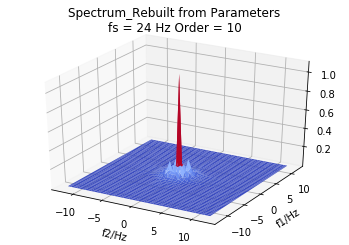

In [11]:
# 将映射关系转换为网络参数
###############################################################
direction, amplifier, spectrum_rebuild = encoder2d(spectrum, 2 * fs * math.pi / N, 2 * math.pi / cycle)
# 将重建之后的频谱中心化
spectrum_rebuild = np.fft.fftshift(spectrum_rebuild)
# 绘制重建的频谱
fig = plt.figure()
spec_rebuild = plt.axes(projection = '3d')
surface = spec_rebuild.plot_surface(fx_grid, fy_grid, abs(spectrum_rebuild), cmap = plt.cm.coolwarm)
plt.title('Spectrum_Rebuilt from Parameters\nfs = %d Hz Order = %d'%(fs, order))
spec_rebuild.set_xlabel('f2/Hz')
spec_rebuild.set_ylabel('f1/Hz')
del spectrum_rebuild, spec_rebuild


76/76 - 0s - loss: 0.7793 - mean_squared_error: 0.7793
1165/1165 - 2s - loss: 0.7839 - mean_squared_error: 0.7839


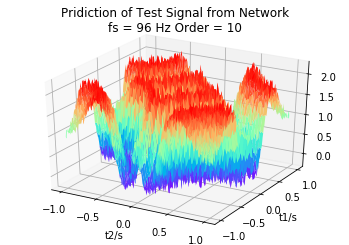

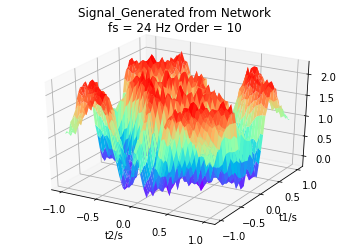

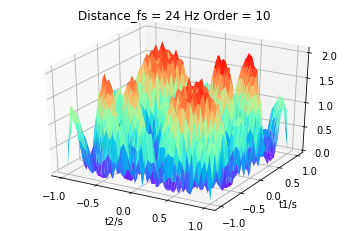

In [12]:
# 生成特定网络表达映射关系
###############################################################
# 初始化网络参数
weight_direction = np.zeros((2, N * N - 1))
weight_amplifier = np.zeros((N * N - 1, 1))
bias = amplifier[0, 0]

# 根据此前编码器的输出将网络参数转换为正确格式
def trans(direction, amplifier):
    N = np.shape(amplifier)[0]
    tick = 0
    for x in range(N):
        for y in range(N):
            if(x == 0 and y == 0):
                continue
            # 从二维一一对应的参数，剔除位置关系转换为一组
            weight_direction[:,tick] = direction[x, y, :]
            weight_amplifier[tick, 0] = amplifier[x, y]
            tick += 1
    return weight_direction, weight_amplifier

weight_direction, weight_amplifier = trans(direction, amplifier)
# 搭建新网络
model_simulator = tf.keras.models.Sequential()
# 输入层为此前的二维数据
model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
# 根据编码器结果给出网络参数以及超参数，激活函数为调用编码器时对应阶数和周期的分部ReLU函数，隐藏层前为方向权重，不需要偏置以符合理论分析
model_simulator.add(tf.keras.layers.Dense(units = N * N - 1, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weight_direction)))
# 输出为一个函数值，激活函数为线性（不需要激活函数）以符合理论分析，隐藏层后为放大权重，将权重和偏置初始化为编码器所得结果
model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(weight_amplifier), bias_initializer = tf.constant_initializer(bias)))
# 优化器Adam,学习率0.01针对本例子是经验值，输出损失函数为均方误差，由于是连续取值映射关系，所以精度指标不能有效描述网络性能
model_simulator.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = 'mean_squared_error', metrics = ['mean_squared_error'])
# 不经过优化依靠编码器给出的权值直接评估网络性能
loss_init, mse = model_simulator.evaluate(x = data, y = label, verbose = 2)
loss_test_init, mse = model_simulator.evaluate(x = data_test, y = label_test, verbose = 2)
# 得到网络预测结果并转换为二维形式方便画图
signal_simulator = model_simulator.predict(data)
signal_simulator = np.reshape(signal_simulator,(N, N))
test = model_simulator.predict(data_test)
test = np.reshape(test,(N_test, N_test))

# 绘制训练集预测面
fig = plt.figure()
signal_simulator_3d = plt.axes(projection = '3d')
surface = signal_simulator_3d.plot_surface(x_test_grid, y_test_grid, test, cmap = 'rainbow')
plt.title('Pridiction of Test Signal from Network\nfs = %d Hz Order = %d'%(fs_test, order))
signal_simulator_3d.set_xlabel('t2/s')
signal_simulator_3d.set_ylabel('t1/s')
signal_simulator_3d.set_xticks(time)
signal_simulator_3d.set_yticks(time)
signal_simulator_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Test_Reconstruct_fs%d.tiff'%(fs_test))
png.close()
del signal_simulator_3d

# 绘制测试集预测面
fig = plt.figure()
signal_simulator_3d = plt.axes(projection = '3d')
surface = signal_simulator_3d.plot_surface(x_grid, y_grid, signal_simulator, cmap = 'rainbow')
plt.title('Signal_Generated from Network\nfs = %d Hz Order = %d'%(fs, order))
signal_simulator_3d.set_xlabel('t2/s')
signal_simulator_3d.set_ylabel('t1/s')
signal_simulator_3d.set_xticks(time)
signal_simulator_3d.set_yticks(time)
signal_simulator_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Reconstruct_fs%d.tiff'%(fs))
png.close()
del signal_simulator_3d

# 绘制差异图
fig = plt.figure()
distance_3d = plt.axes(projection = '3d')
surface = distance_3d.plot_surface(x_grid, y_grid, abs(np.reshape(signal_simulator, (N, N)) - signal), cmap = 'rainbow')
plt.title('Distance_fs = %d Hz Order = %d'%(fs, order))
distance_3d.set_xlabel('t2/s')
distance_3d.set_ylabel('t1/s')
distance_3d.set_xticks(time)
distance_3d.set_yticks(time)
distance_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Distance_fs%d_order%d.tiff'%(fs, order))
png.close()
del distance_3d, signal_simulator


49/49 - 1s - loss: 9.4286 - mean_squared_error: 9.4286
49/49 - 0s - loss: 1.1898 - mean_squared_error: 1.1898
49/49 - 0s - loss: 0.6921 - mean_squared_error: 0.6921
49/49 - 0s - loss: 0.5357 - mean_squared_error: 0.5357
49/49 - 0s - loss: 0.3200 - mean_squared_error: 0.3200
49/49 - 0s - loss: 0.2359 - mean_squared_error: 0.2359
49/49 - 0s - loss: 0.1414 - mean_squared_error: 0.1414
49/49 - 0s - loss: 0.0973 - mean_squared_error: 0.0973
49/49 - 0s - loss: 0.0451 - mean_squared_error: 0.0451
49/49 - 0s - loss: 0.0236 - mean_squared_error: 0.0236
MSE_Direction = 0.007173, 0.006896
MSE_Amplifier = 0.000523
MSE_Bias = 0.000064
MSE_TestSignal = 0.022395


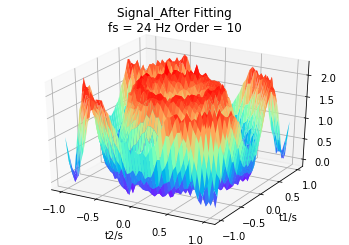

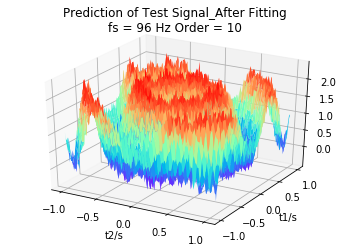

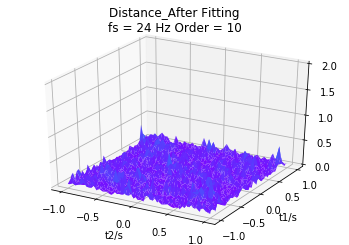

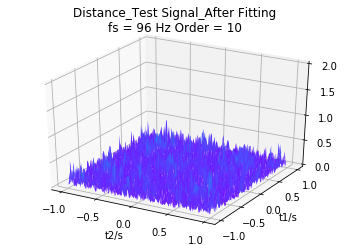

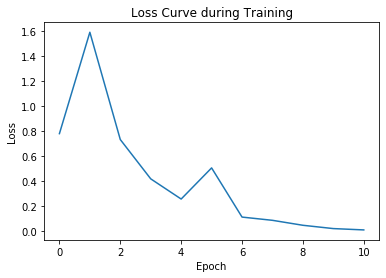

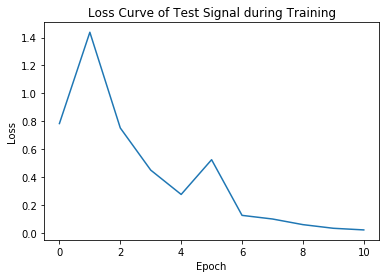

In [13]:
# 查看以频谱给出的参数为初始化条件下训练的结果
###############################################################
loss = np.zeros(11)
loss_test = np.zeros(11)
loss[0] = loss_init
loss_test[0] = loss_test_init
for cx in range(1, 11):
    model_simulator.fit(x = data, y = label, batch_size = N, epochs = 1, verbose = 2)
    loss[cx], mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
    loss_test[cx], mse = model_simulator.evaluate(x = data_test, y = label_test, verbose = 0)
# 得到网络预测结果并转换为二维形式方便画图
signal_simulator = model_simulator.predict(data)
signal_simulator = np.reshape(signal_simulator,(N, N))
test = model_simulator.predict(data_test)
test = np.reshape(test,(N_test, N_test))

# 绘制预测面
fig = plt.figure()
signal_simulator_3d = plt.axes(projection = '3d')
surface = signal_simulator_3d.plot_surface(x_grid, y_grid, signal_simulator, cmap = 'rainbow')
plt.title('Signal_After Fitting\nfs = %d Hz Order = %d'%(fs, order))
signal_simulator_3d.set_xlabel('t2/s')
signal_simulator_3d.set_ylabel('t1/s')
signal_simulator_3d.set_xticks(time)
signal_simulator_3d.set_yticks(time)
signal_simulator_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Trained.tiff')
png.close()
del signal_simulator_3d

# 绘制预测面
fig = plt.figure()
signal_simulator_3d = plt.axes(projection = '3d')
surface = signal_simulator_3d.plot_surface(x_test_grid, y_test_grid, test, cmap = 'rainbow')
plt.title('Prediction of Test Signal_After Fitting\nfs = %d Hz Order = %d'%(fs_test, order))
signal_simulator_3d.set_xlabel('t2/s')
signal_simulator_3d.set_ylabel('t1/s')
signal_simulator_3d.set_xticks(time)
signal_simulator_3d.set_yticks(time)
signal_simulator_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Test_Trained.tiff')
png.close()
del signal_simulator_3d

# 绘制差异图
fig = plt.figure()
distance_3d = plt.axes(projection = '3d')
surface = distance_3d.plot_surface(x_grid, y_grid, abs(np.reshape(signal_simulator, (N, N)) - signal), cmap = 'rainbow', vmin = 0, vmax = 2)
plt.title('Distance_After Fitting\nfs = %d Hz Order = %d'%(fs, order))
distance_3d.set_xlabel('t2/s')
distance_3d.set_ylabel('t1/s')
distance_3d.set_xticks(time)
distance_3d.set_yticks(time)
distance_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Distance_Trained.tiff')
png.close()
del distance_3d, signal_simulator

# 绘制差异图
fig = plt.figure()
distance_3d = plt.axes(projection = '3d')
surface = distance_3d.plot_surface(x_test_grid, y_test_grid, abs(np.reshape(test, (N_test, N_test)) - signal_test), cmap = 'rainbow', vmin = 0, vmax = 2)
plt.title('Distance_Test Signal_After Fitting\nfs = %d Hz Order = %d'%(fs_test, order))
distance_3d.set_xlabel('t2/s')
distance_3d.set_ylabel('t1/s')
distance_3d.set_xticks(time)
distance_3d.set_yticks(time)
distance_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Distance_Test_Trained.tiff')
png.close()
del distance_3d, test

# 绘制训练损失变化曲线
fig = plt.figure()
plt.plot(range(0, 11), loss)
plt.title('Loss Curve during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Loss-epoch.tiff')
png.close()

# 绘制训练损失变化曲线
fig = plt.figure()
plt.plot(range(0, 11), loss_test)
plt.title('Loss Curve of Test Signal during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Loss_test-epoch.tiff')
png.close()

# 计算网络参数变动
num = N * N - 1
# 得到训练后网络参数
direction_fit = weightshare(model_simulator, (2, num))
amplifier_fit = weightshare(model_simulator, (num, 1))
bias_fit = weightshare(model_simulator, (1, ))
# 初始化存放mse列表
direction_mse = np.zeros(2)
amplifier_mse = 0
# 计算偏置均方误差
bias_mse = math.pow(bias - bias_fit[0], 2)
# 计算权重平方和
for tick in range(num):
    direction_mse[0] += math.pow(weight_direction[0, tick] - direction_fit[0, tick], 2)
    direction_mse[1] += math.pow(weight_direction[1, tick] - direction_fit[1, tick], 2)
    amplifier_mse += math.pow(weight_amplifier[tick, 0] - amplifier_fit[tick, 0], 2)
# 对权重平方和求平均
direction_mse /= num
amplifier_mse /= num
# 打印结果
print('MSE_Direction = %f, %f'%(direction_mse[0], direction_mse[1]))
print('MSE_Amplifier = %f'%amplifier_mse)
print('MSE_Bias = %f'%bias_mse)
print('MSE_TestSignal = %f'%loss_test[-1])


No.1 done!
No.2 done!
No.3 done!
No.4 done!


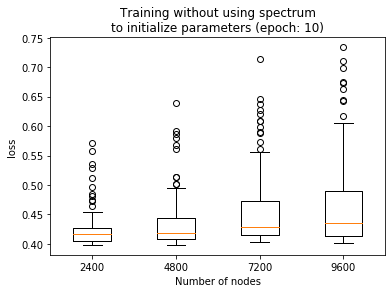

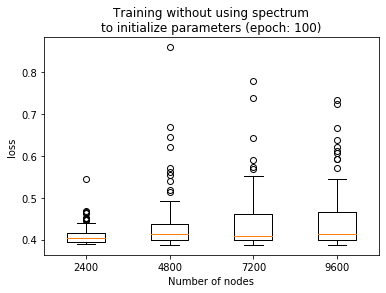

In [14]:
# 不经过频谱初始化，按照一般随机初始化方法训练
###############################################################
# 初始化网络损失列表
loss_10 = []
loss_100 = []
# 初始化节点数坐标
tick = []
# 分别计算相比频谱初始化参数网络，不同倍数的隐藏层节点数（1倍、4倍、7倍、10倍）下随机初始化训练结果
for j in range(1, 5):
    # 为损失箱线图（列表）添加第一幅子图（列表）
    loss_10.append([])
    loss_100.append([])
    # 计算当下节点数
    node = (N * N - 1) * j
    # 添加子图标签
    tick.append(str(node))
    # 独立训练100次，统计训练结果
    for i in range(100):
        model_simulator = tf.keras.models.Sequential()
        model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
        model_simulator.add(tf.keras.layers.Dense(units = node, activation = tf.function(ReLU_apart), use_bias = False))
        model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
        # 保持学习率一致
        model_simulator.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = 'mean_squared_error', metrics = ['mean_squared_error'])
        # 记录epoch10的损失数据
        model_simulator.fit(x = data, y = label, batch_size = N, epochs = 10, verbose = 0)
        # 计算损失
        ax, mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
        # 为新子图添加数据
        loss_10[-1].append(ax)
        # 记录epoch100的损失数据
        model_simulator.fit(x = data, y = label, batch_size = N, epochs = 90, verbose = 0)
        # 计算损失
        ax, mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
        # 为新子图添加数据
        loss_100[-1].append(ax)
        del model_simulator
    print('No.%d done!'%j)

# 绘制不同隐藏层节点数下的箱线图,epoch:10
fig = plt.figure()
plt.boxplot(tuple(loss_10), labels = tuple(tick))
plt.title('Training without using spectrum\nto initialize parameters (epoch: 10)')
plt.xlabel('Number of nodes')
plt.ylabel('loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Training_without_using_spectrum_10.tiff')
png.close()

# 绘制不同隐藏层节点数下的箱线图,epoch:100
fig = plt.figure()
plt.boxplot(tuple(loss_100), labels = tuple(tick))
plt.title('Training without using spectrum\nto initialize parameters (epoch: 100)')
plt.xlabel('Number of nodes')
plt.ylabel('loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Training_without_using_spectrum_100.tiff')
png.close()


Calculation for Disturbance(15%) is Done


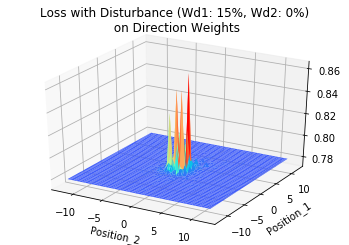

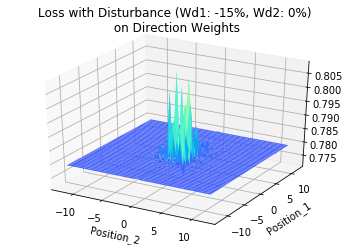

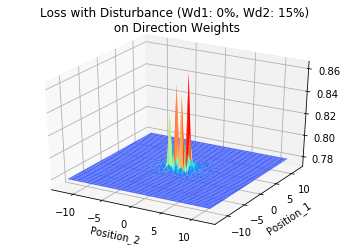

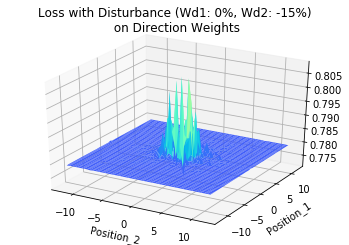

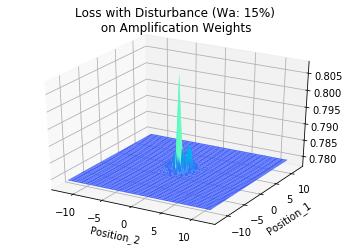

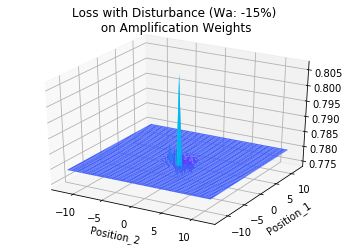

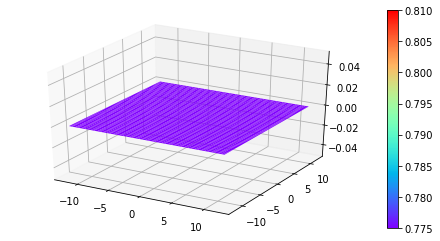

In [15]:
# 对重建的网络参数进行灵敏度分析
###############################################################
# 构建网络返回均方误差
def network(weight_direction, weight_amplifier, bias, data, label, num):
    model_simulator = tf.keras.models.Sequential()
    model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
    model_simulator.add(tf.keras.layers.Dense(units = num, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weight_direction)))
    model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(weight_amplifier), bias_initializer = tf.constant_initializer(bias)))
    model_simulator.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
    loss , mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
    return loss

# 初始化结果列表，共计遍历3种扰动
direction_sensitivity = np.zeros((3, 4, N, N))
amplifier_sensitivity = np.zeros((3, 2, N, N))
# 初始化方向向量
symbols_direction = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
symbols_amplifier = np.array([1, -1])
# 初始化存放原始值
direction_originvalue = np.zeros(2)
amplifier_originvalue = 0
# 遍历扰动
for tick in range(3, 4):
    # 扰动以5%为间隔
    disturb = 0.05 * tick
    # 遍历每一个位置
    for x in range(N):
        for y in range(N):
            # 保存原始方向向量
            direction_originvalue[0] = direction[x, y, 0]
            direction_originvalue[1] = direction[x, y, 1]
            # 遍历方向权重的4个方向
            for cx in range(4):
                # 提取本次的方向
                symbol = symbols_direction[cx]
                # 为方向向量添加扰动
                direction[x, y, 0] = direction_originvalue[0] * (1 + symbol[0] * disturb)
                direction[x, y, 1] = direction_originvalue[1] * (1 + symbol[1] * disturb)
                # 得到对应方向向量和放大向量列表
                weight_direction, weight_amplifier = trans(direction, amplifier)
                # 构建网络得到该扰动下的损失
                direction_sensitivity[tick - 1, cx, x, y] = network(weight_direction, weight_amplifier, amplifier[0, 0], data, label, num)
                # 变回原值
                direction[x, y, 0] = direction_originvalue[0]
                direction[x, y, 1] = direction_originvalue[1]
            # 保存原始放大权重值
            amplifier_originvalue = amplifier[x, y]
            # 遍历放大权重的两个方向
            for cx in range(2):
                # 提取本次的方向
                symbol = symbols_amplifier[cx]
                # 添加本次的扰动
                amplifier[x, y] = amplifier_originvalue * (1 + symbol * disturb)
                # 得到对应方向向量和放大向量列表
                weight_direction, weight_amplifier = trans(direction, amplifier)
                # 构建网络得到该扰动下的损失
                amplifier_sensitivity[tick - 1, cx, x, y] = network(weight_direction, weight_amplifier, amplifier[0, 0], data, label, num)
                # 变回原值
                amplifier[x, y] = amplifier_originvalue
    # 绘制方向权重扰动损失图
    for cx in range(4):
        fig = plt.figure(figsize = (6, 4))
        direction_3d = plt.axes(projection = '3d')
        surface = direction_3d.plot_surface(fx_grid, fy_grid, np.fft.fftshift(direction_sensitivity[tick - 1, cx, :, :]), cmap = 'rainbow', vmin = 0.775, vmax = 0.81)
        plt.title('Loss with Disturbance (Wd1: %d%%, Wd2: %d%%)\n on Direction Weights'%(int(disturb * symbols_direction[cx][0] * 100), int(disturb * symbols_direction[cx][1] * 100)))
        direction_3d.set_xlabel('Position_2')
        direction_3d.set_ylabel('Position_1')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Disturbance_w1%dw2%d.tiff'%(int(disturb * symbols_direction[cx][0] * 100), int(disturb * symbols_direction[cx][1] * 100)))
        png.close()
        del direction_3d
    # 绘制放大权重扰动平均损失图
    for cx in range(2):
        fig = plt.figure(figsize = (6, 4))
        amplifier_3d = plt.axes(projection = '3d')
        surface = amplifier_3d.plot_surface(fx_grid, fy_grid, np.fft.fftshift(amplifier_sensitivity[tick - 1, cx, :, :]), cmap = 'rainbow', vmin = 0.775, vmax = 0.81)
        plt.title('Loss with Disturbance (Wa: %d%%)\n on Amplification Weights'%(disturb * symbols_amplifier[cx] * 100))
        amplifier_3d.set_xlabel('Position_2')
        amplifier_3d.set_ylabel('Position_1')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Disturbance_a%d.tiff'%(disturb * symbols_amplifier[cx] * 100))
        png.close()
        del amplifier_3d
    print('Calculation for Disturbance(%d%%) is Done'%(disturb * 100))

# 绘制颜色棒
fig = plt.figure(figsize = (8, 4))
color_3d = plt.axes(projection = '3d')
surface = color_3d.plot_surface(fx_grid, fy_grid, np.zeros((N, N)), cmap = 'rainbow', vmin = 0.775, vmax = 0.81)
fig.colorbar(surface)

del direction_sensitivity, amplifier_sensitivity, symbols_direction, symbols_amplifier


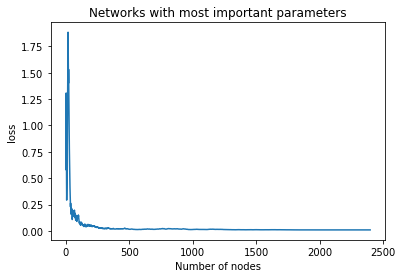

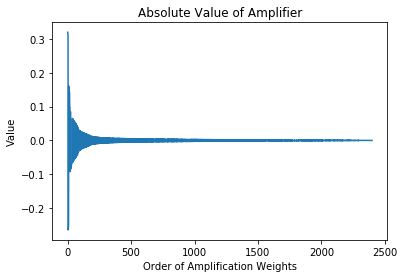

In [16]:
# 区分结点的重要性，为剪枝提供依据
###############################################################
# 参数按照放大权重绝对值大小从大到小排序；对坐标快速排序
def quick(tick, amplifier):
    # 列表为空则返回
    if tick == []:
        return []
    # 初始化存放比较大的数值的列表
    left = []
    # 初始化存放比较小的数值的列表
    right = []
    # 提取第一个用于比较
    loc = tick[0]
    # 遍历比较
    for i in tick[1: ]:
        # 绝对值较大的在前，否则在后
        if abs(amplifier[i]) >= abs(amplifier[loc]):
            left.append(i)
        else:
            right.append(i)
    # 组合递归结果输出
    return quick(left, amplifier) + [loc] + quick(right, amplifier)

# 得到按照放大权重绝对值大小排序后的坐标
tick = quick(range(num), amplifier_fit)
# 初始化排序以后存放权重的数组
direction_regular = np.zeros((2, num))
amplifier_regular = np.zeros((num, 1))
# 将权重按照坐标顺序重新排序
for i in range(num):
    direction_regular[: , i] = direction_fit[: , tick[i]]
    amplifier_regular[i, 0] = amplifier_fit[tick[i], 0]

# 初始化损失随重要参数依次放入网络的变化曲线
loss_regular = np.zeros(num)
# 按顺序将节点接入网络查看网络性能
for i in range(num):
    loss_regular[i] = network(direction_regular[: , : i + 1], amplifier_regular[: i + 1, : ], bias_fit, data, label, i + 1)
# 绘制损失变化曲线
plt.figure()
plt.plot(range(num), loss_regular)
plt.title('Networks with most important parameters')
plt.xlabel('Number of nodes')
plt.ylabel('loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Loss_Sort.tiff')
png.close()
# 按序绘制放大权重绝对值
plt.figure()
plt.plot(range(num), amplifier_regular)
plt.title('Absolute Value of Amplifier')
plt.xlabel('Order of Amplification Weights')
plt.ylabel('Value')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Amplifier_Sort.tiff')
png.close()


MSE of Network with 200 Most Important Nodes: 0.052707


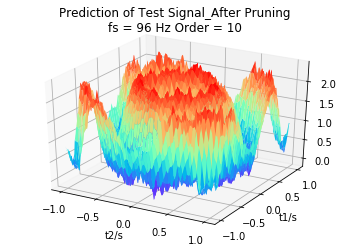

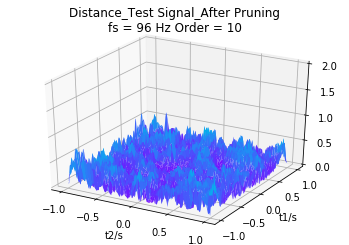

In [17]:
# 依节点重要性剪枝
###############################################################
# 构建网络，保留放大权重最大的200个节点
model_simulator = tf.keras.models.Sequential()
model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
model_simulator.add(tf.keras.layers.Dense(units = 200, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(direction_regular[: , : 200])))
model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(amplifier_regular[: 200, : ]), bias_initializer = tf.constant_initializer(bias_fit)))
model_simulator.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
# 运用测试集查看网络输出
test = model_simulator.predict(data_test)
test = np.reshape(test,(N_test, N_test))

# 绘制预测面
fig = plt.figure()
signal_simulator_3d = plt.axes(projection = '3d')
surface = signal_simulator_3d.plot_surface(x_test_grid, y_test_grid, test, cmap = 'rainbow')
plt.title('Prediction of Test Signal_After Pruning\nfs = %d Hz Order = %d'%(fs_test, order))
signal_simulator_3d.set_xlabel('t2/s')
signal_simulator_3d.set_ylabel('t1/s')
signal_simulator_3d.set_xticks(time)
signal_simulator_3d.set_yticks(time)
signal_simulator_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Test_Cut.tiff')
png.close()
del signal_simulator_3d

# 绘制差异图
fig = plt.figure()
distance_3d = plt.axes(projection = '3d')
surface = distance_3d.plot_surface(x_test_grid, y_test_grid, abs(np.reshape(test, (N_test, N_test)) - signal_test), cmap = 'rainbow', vmin = 0, vmax = 2)
plt.title('Distance_Test Signal_After Pruning\nfs = %d Hz Order = %d'%(fs_test, order))
distance_3d.set_xlabel('t2/s')
distance_3d.set_ylabel('t1/s')
distance_3d.set_xticks(time)
distance_3d.set_yticks(time)
distance_3d.set_zticks(value)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Distance_Test_Cut.tiff')
png.close()
del distance_3d, test

print('MSE of Network with 200 Most Important Nodes: %f'%loss_regular[199])

del direction_regular, amplifier_regular, direction_fit, amplifier_fit, bias_fit


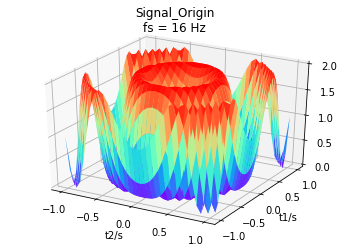

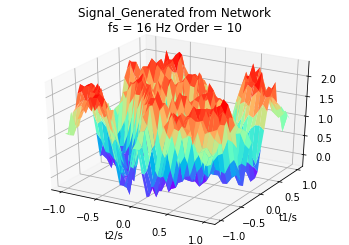

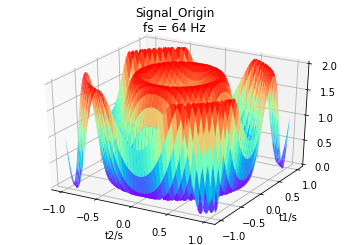

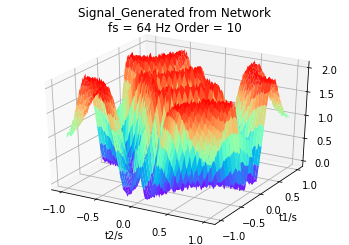

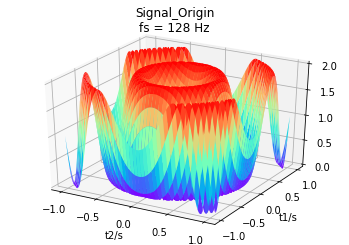

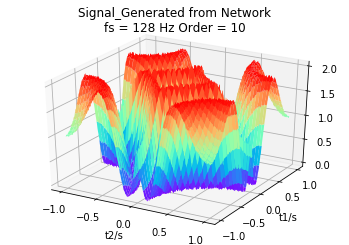

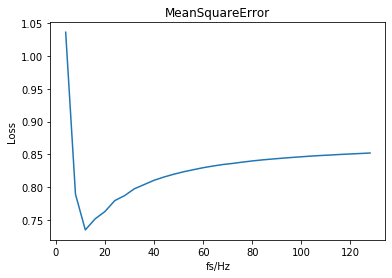

In [18]:
# 查看样点数目对生成网络的影响
###############################################################
# 固定阶数
order = 10
Bk, Dk = Coefficient()
Ck = Coefficient_complex()
f = np.array([tick for tick in range(4, 132, 4)])
loss = np.zeros(32)
# 代码均参考此前实验代码，循环更改采样率
for fs in range(4, 132, 4):
    N = 2 * fs + 1
    signal = np.zeros((N, N))
    data = np.zeros((N * N, 2))
    label = np.zeros(N * N)
    tick = 0
    # 生成信号
    t = np.array([tick / fs for tick in range(-fs, fs + 1)])
    for cx in range(N):
        for ax in range(N):
            signal[cx, ax] = math.sin(2 * math.pi * (f1 * math.pow(t[cx], 2) + f2 * math.pow(t[ax], 2))) + 1
            data[tick, 0], data[tick, 1] = t[cx], t[ax]
            label[tick] = signal[cx, ax]
            tick += 1
    # 计算频谱
    spectrum = np.fft.fft2(signal) / math.pow(N, 2)
    # 计算网络参数
    direction, amplifier, spectrum_rebuild = encoder2d(spectrum, 2 * fs * math.pi / N, 2 * math.pi / cycle)
    weight_direction = np.zeros((2, N * N - 1))
    weight_amplifier = np.zeros((N * N - 1, 1))
    bias = amplifier[0, 0].real
    tick = 0
    for x in range(N):
        for y in range(N):
            if(x == 0 and y == 0):
                continue
            weight_direction[:,tick] = direction[x, y, :]
            weight_amplifier[tick, 0] = amplifier[x, y]
            tick += 1
    # 依参数构建网络
    model_simulator = tf.keras.models.Sequential()
    model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
    model_simulator.add(tf.keras.layers.Dense(units = N * N - 1, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weight_direction)))
    model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(weight_amplifier), bias_initializer = tf.constant_initializer(bias)))
    model_simulator.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
    loss[int(fs / 4 - 1)], mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
    # 绘制原始信号和网络生成信号
    if(fs == 16 or fs == 64 or fs == 128):
        # 生成预测数据
        signal_simulator = model_simulator.predict(data)
        signal_simulator = np.reshape(signal_simulator,(N, N))
        x_grid, y_grid = np.meshgrid(t, t)
        fig = plt.figure()
        data_3d = plt.axes(projection = '3d')
        surface = data_3d.plot_surface(x_grid, y_grid, signal, cmap = 'rainbow')
        plt.title('Signal_Origin\nfs = %d Hz'%fs)
        data_3d.set_xlabel('t2/s')
        data_3d.set_ylabel('t1/s')
        data_3d.set_xticks(time)
        data_3d.set_yticks(time)
        data_3d.set_zticks(value)
        fig = plt.figure()
        signal_simulator_3d = plt.axes(projection = '3d')
        surface = signal_simulator_3d.plot_surface(x_grid, y_grid, signal_simulator, cmap = 'rainbow')
        plt.title('Signal_Generated from Network\nfs = %d Hz Order = %d'%(fs, order))
        signal_simulator_3d.set_xlabel('t2/s')
        signal_simulator_3d.set_ylabel('t1/s')
        signal_simulator_3d.set_xticks(time)
        signal_simulator_3d.set_yticks(time)
        signal_simulator_3d.set_zticks(value)
        del signal_simulator_3d, data_3d
    del model_simulator

# 绘制损失—采样率曲线
fig = plt.figure()
plt.plot(f, loss)
plt.title('MeanSquareError')
plt.xlabel('fs/Hz')
plt.ylabel('Loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MSE_Fs.tiff')
png.close()


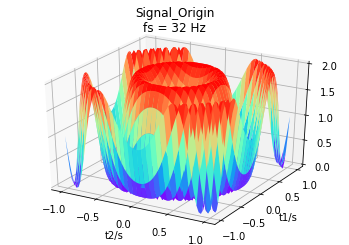

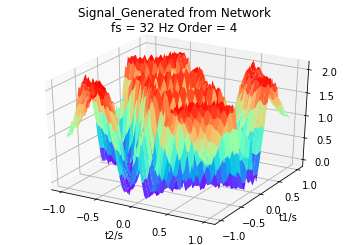

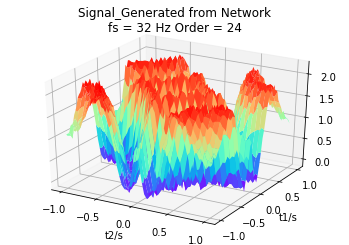

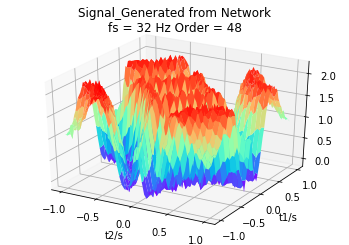

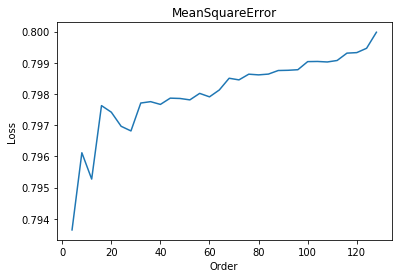

In [19]:
# 查看阶数对生成网络的影响
###############################################################
loss = np.zeros(32)
# 固定采样率
fs = 32
N = 2 * fs + 1
signal = np.zeros((N, N))
data = np.zeros((N * N, 2))
label = np.zeros(N * N)
tick = 0
t = np.array([tick / fs for tick in range(-fs, fs + 1)])
# 生成信号
for cx in range(N):
    for ax in range(N):
        signal[cx, ax] = math.sin(2 * math.pi * (f1 * math.pow(t[cx], 2) + f2 * math.pow(t[ax], 2))) + 1
        data[tick, 0], data[tick, 1] = t[cx], t[ax]
        label[tick] = signal[cx, ax]
        tick += 1

# 绘制原始信号
x_grid, y_grid = np.meshgrid(t, t)
fig = plt.figure()
data_3d = plt.axes(projection = '3d')
surface = data_3d.plot_surface(x_grid, y_grid, signal, cmap = 'rainbow')
plt.title('Signal_Origin\nfs = %d Hz'%fs)
data_3d.set_xlabel('t2/s')
data_3d.set_ylabel('t1/s')
data_3d.set_xticks(time)
data_3d.set_yticks(time)
data_3d.set_zticks(value)
del data_3d

# 计算频谱
spectrum = np.fft.fft2(signal) / math.pow(N, 2)
# 代码均参考此前实验代码，循环更改激活函数Fourier级数阶数
for order in range(2, 66, 2):
    # 重新得到系数
    Bk, Dk = Coefficient()
    Ck = Coefficient_complex()
    # 计算网络参数
    direction, amplifier, spectrum_rebuild = encoder2d(spectrum, 2 * fs * math.pi / N, 2 * math.pi / cycle)
    weight_direction = np.zeros((2, N * N - 1))
    weight_amplifier = np.zeros((N * N - 1, 1))
    bias = amplifier[0, 0].real
    tick = 0
    for x in range(N):
        for y in range(N):
            if(x == 0 and y == 0):
                continue
            weight_direction[:,tick] = direction[x, y, :]
            weight_amplifier[tick, 0] = amplifier[x, y]
            tick += 1
    # 依参数构建网络
    model_simulator = tf.keras.models.Sequential()
    model_simulator.add(tf.keras.layers.InputLayer(input_shape = 2))
    model_simulator.add(tf.keras.layers.Dense(units = N * N - 1, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(weight_direction)))
    model_simulator.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(weight_amplifier), bias_initializer = tf.constant_initializer(bias)))
    model_simulator.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
    loss[int(order / 2 - 1)], mse = model_simulator.evaluate(x = data, y = label, verbose = 0)
    # 绘制原始信号和网络生成信号
    if(order == 4 or order == 24 or order == 48):
        # 生成预测数据
        signal_simulator = model_simulator.predict(data)
        signal_simulator = np.reshape(signal_simulator,(N, N))
        fig = plt.figure()
        signal_simulator_3d = plt.axes(projection = '3d')
        surface = signal_simulator_3d.plot_surface(x_grid, y_grid, signal_simulator, cmap = 'rainbow')
        plt.title('Signal_Generated from Network\nfs = %d Hz Order = %d'%(fs, order))
        signal_simulator_3d.set_xlabel('t2/s')
        signal_simulator_3d.set_ylabel('t1/s')
        signal_simulator_3d.set_xticks(time)
        signal_simulator_3d.set_yticks(time)
        signal_simulator_3d.set_zticks(value)
        del signal_simulator_3d
    del model_simulator

# 绘制损失—阶数曲线
fig = plt.figure()
plt.plot(f, loss)
plt.title('MeanSquareError')
plt.xlabel('Order')
plt.ylabel('Loss')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('MSE_Order.tiff')
png.close()


In [20]:
# 定义解码器
###############################################################
# 将网络解码为频谱信息并预测网络输出
def decoder(t, direction, amplifier, bias, w0):
    # 统计参数组数量
    num = np.shape(amplifier)[0]
    # 统计输入数据数
    N = np.shape(t)[0]
    # 初始化预测列表
    signal = np.zeros(N)
    # 循环为每个输入数据预测输出值
    for tick in range(N):
        # 循环计算每组网络参数对输出的贡献
        for cx in range(num):
            # 提取方向权重并计算三角级数频率量单位
            direct = direction[0, cx] * w0 * t[tick]
            # 提取放大权重值
            amplify = amplifier[cx, 0]
            # 初始化该组参数影响
            interval = 0
            # 按阶次循环计算每阶分量的影响
            for ax in range(1, order + 1):
                # 计算对应阶次频率量
                w = direct * ax
                # 添加对应阶次影响
                interval += (Bk[ax] * math.cos(w) - Dk[ax] * math.sin(w)) * 2
            # 添加对应参数组直流量影响
            interval += Ck[0]
            # 对该参数组影响进行放大
            interval *= amplify
            # 将该参数组的影响添加到对应输入数据的输出预测中
            signal[tick] += interval
        # 添加直流分量的影响
        signal[tick] += bias[0]
    return signal

# 将网络参数解码为频谱
def decoder_spec(direction, amplifier, bias, w0):
    # 初始化存放频谱信息的字典
    spec = {}
    # 初始化直流分量为0
    spec[0] = 0
    # 统计参数组数量
    num = np.shape(amplifier)[0]
    # 依每个节点依次绘制频谱信息
    for i in range(num):
        # 叠加直流
        spec[0] += Ck[0] * amplifier[i, 0]
        # 依阶次叠加交流
        for j in range(1, order + 1):
            # 计算绘制谱线的位置
            loc = direction[0, i] * w0 * j
            # 叠加正方向频谱
            spec[loc] = spec.get(loc, 0) + Ck[j] * amplifier[i, 0]
            # 叠加负方向频谱
            spec[-loc] = spec.get(-loc, 0) + Ck[-j] * amplifier[i, 0]
    # 叠加偏置量到直流
    spec[0] += bias[0]
    return spec


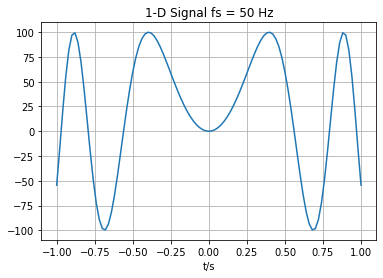

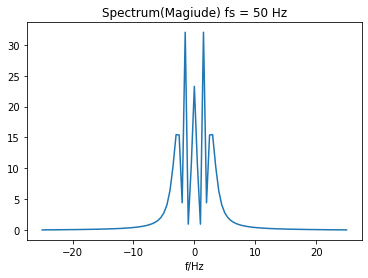

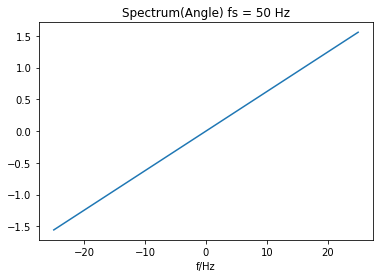

In [21]:
# 绘制一维信号
###############################################################
# 重新计算系数
order = 3
Bk, Dk = Coefficient()
Ck = Coefficient_complex()

# 生成信号
fs = 50
fs_test = 200
N = fs * 2 + 1
N_test = fs_test * 2 + 1
w0 = 2 * math.pi / cycle
signal = np.zeros(N)
signal_test = np.zeros(N_test)
t = np.array([tick / fs for tick in range(-fs, fs + 1)])
t_test = np.array([tick / fs_test for tick in range(-fs_test, fs_test + 1)])
f = np.array([tick / 2 for tick in range(-fs, fs + 1)])
for cx in range(N):
    # 该信号的频率和大小是经过设计的，目的是让方向权重和放大权重在同一个网络学习率下均能够有效学习
    signal[cx] = 100 * math.sin(10 * math.pow(t[cx], 2))
for cx in range(N_test):
    # 该信号的频率和大小是经过设计的，目的是让方向权重和放大权重在同一个网络学习率下均能够有效学习
    signal_test[cx] = 100 * math.sin(10 * math.pow(t_test[cx], 2))

# 绘制信号图
fig = plt.figure()
plt.plot(t, signal)
plt.title('1-D Signal fs = %d Hz'%fs)
plt.grid()
plt.xlabel('t/s')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_Origin_1D.tiff')
png.close()

# 计算频谱幅值和相位
spectrum = np.fft.fft(signal) / N
spectrum = np.fft.fftshift(spectrum)
mag = []
ang = []
for i, value in enumerate(spectrum):
    mag.append(abs(value))
    ang.append(math.atan(value.imag / value.real))

# 绘制信号FFT幅值图像
fig = plt.figure()
plt.plot(f, mag)
plt.title('Spectrum(Magiude) fs = %d Hz'%fs)
plt.xlabel('f/Hz')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Spectrum_Magiude_Origin_1D.tiff')
png.close()

# 绘制信号FFT相位图像
fig = plt.figure()
plt.plot(f, ang)
plt.title('Spectrum(Angle) fs = %d Hz'%fs)
plt.xlabel('f/Hz')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Spectrum_Angle_Origin_1D.tiff')
png.close()


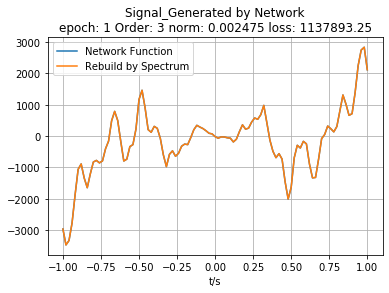

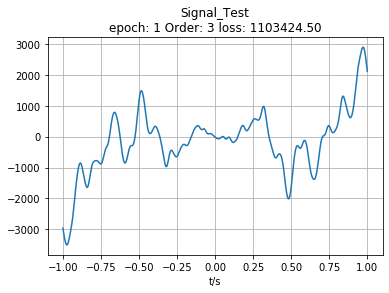

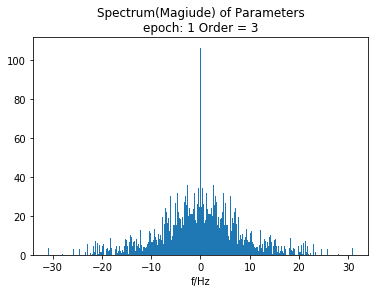

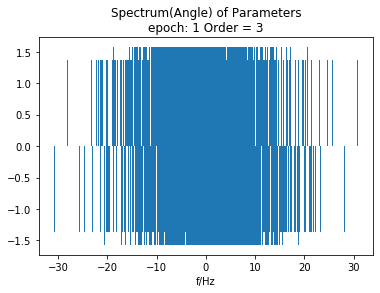

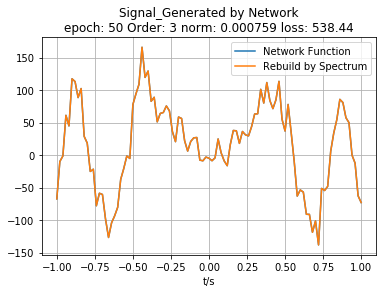

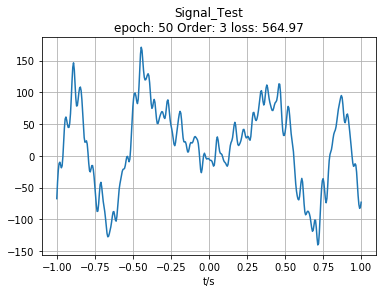

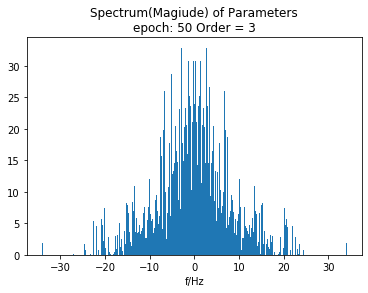

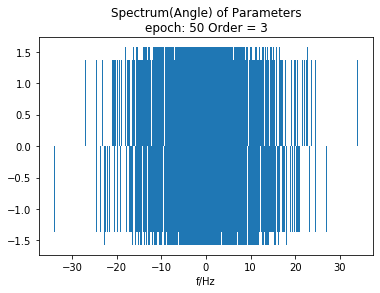

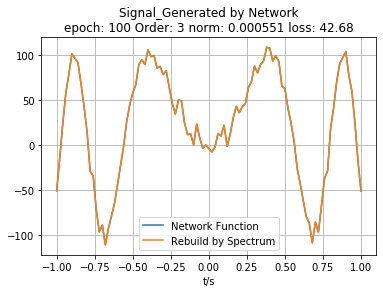

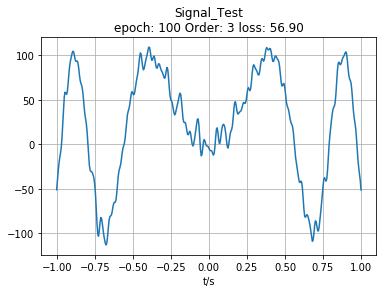

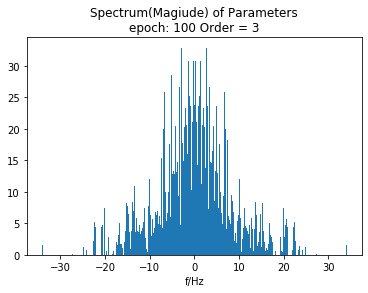

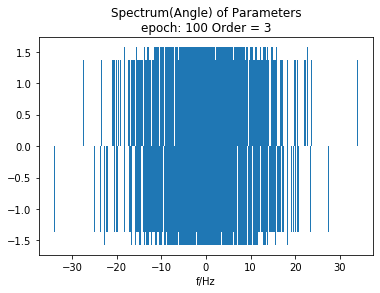

In [22]:
# 考察训练过程网络参数变化对频谱的影响
###############################################################
# 构建网络
model_analysis = tf.keras.models.Sequential()
model_analysis.add(tf.keras.layers.InputLayer(input_shape = 1))
# 网络权重初始化的方差是参考信号频谱给出的，由于频域范围是25，于是为了保证方向权重能触及该频率上限于是定为标准差20
# 由此前的实现知，理想情况下网络隐藏层节点应不小于N-1，考虑到大多数网络节点数都远大于需求于是定为4N
model_analysis.add(tf.keras.layers.Dense(units = N * 4, activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(np.random.normal(0, 20, [1, N * 4]))))
# 超参数选取策略同上
model_analysis.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(np.random.normal(0, 20, [N * 4, 1])), bias_initializer = tf.constant_initializer(np.random.normal(0, 20, [1, ]))))
# 规定学习率为1，是考虑到参数量级，同时也是经过多次实验得到的经验值
model_analysis.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1), loss = 'mean_squared_error', metrics = ['mean_squared_error'])

# 循环训练
for cx in range(1, 101):
    # 每次训练一个epoch
    model_analysis.fit(x = t, y = signal, batch_size = N, epochs = 1, verbose = 0)
    # 选取三个阶段显示实验结果
    if(cx == 1 or cx == 50 or cx == 100):
        # 得到频率意义上重建的信号
        signal_rebuild = decoder(t, weightshare(model_analysis, [1, N * 4]), weightshare(model_analysis, [N * 4, 1]), weightshare(model_analysis, [1, ]), w0)
        # 得到网络频谱
        signal_spec = decoder_spec(weightshare(model_analysis, [1, N * 4]), weightshare(model_analysis, [N * 4, 1]), weightshare(model_analysis, [1, ]), w0)
        # 得到网络输出的预测值
        signal_net = model_analysis.predict(t)
        loss, mse = model_analysis.evaluate(x = t, y = signal, verbose = 0)
        # 计算测试集输出
        signal_net_test = model_analysis.predict(t_test)
        loss_test, mse = model_analysis.evaluate(x = t_test, y = signal_test, verbose = 0)
        # 计算两个预测输出的最大值范数
        sub = max(abs(signal_rebuild - np.reshape(signal_net, (N, ))))
        # 绘制网络曲线
        fig = plt.figure()
        signal_net = plt.plot(t, signal_net, label = 'Network Function')
        signal_weight = plt.plot(t, signal_rebuild, label = 'Rebuild by Spectrum')
        plt.grid()
        plt.legend()
        plt.title('Signal_Generated by Network\nepoch: %d Order: %d norm: %f loss: %.2f'%(cx, order, sub, loss))
        plt.xlabel('t/s')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Signal_NetworkRebuild_1D_epoch%d.tiff'%(cx))
        png.close()
        # 绘制泛化曲线
        fig = plt.figure()
        signal_net_test = plt.plot(t_test, signal_net_test)
        plt.grid()
        plt.title('Signal_Test\nepoch: %d Order: %d loss: %.2f'%(cx, order, loss_test))
        plt.xlabel('t/s')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Signal_Test_1D_epoch%d.tiff'%(cx))
        png.close()
        # 绘制网络频谱
        f = list(signal_spec.keys())
        mag = []
        ang = []
        for i, value in enumerate(f):
            f[i] = value / math.pi / 2
        spec = list(signal_spec.values())
        for i, value in enumerate(spec):
            mag.append(abs(value))
            ang.append(math.atan(value.imag / value.real))
        plt.figure()
        plt.bar(f, mag, width = 0.2)
        plt.title('Spectrum(Magiude) of Parameters\nepoch: %d Order = %d'%(cx, order))
        plt.xlabel('f/Hz')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Spectrum_Magiude_Network_1D_epoch%d.tiff'%(cx))
        png.close()
        plt.figure()
        plt.bar(f, ang, width = 0.2)
        plt.title('Spectrum(Angle) of Parameters\nepoch: %d Order = %d'%(cx, order))
        plt.xlabel('f/Hz')
        png = io.BytesIO()
        plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
        tiff = Image.open(png)
        tiff.save('Spectrum_Angle_Network_1D_epoch%d.tiff'%(cx))
        png.close()

del model_analysis, signal_rebuild, signal_spec, signal_net, mag, ang


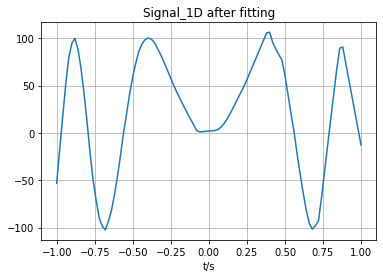

In [23]:
# 构建多层网络训练一维信号
###############################################################
# 输入一维信号
inputs = tf.keras.Input(shape = (1, ))
# 节点数选取为经验值，因为要提取第一层参数映射频谱因此选择有限项级数的Relu作为激活且不带偏置项
Dense_1 = tf.keras.layers.Dense(units = N * 2, activation = tf.function(ReLU_apart), use_bias = False)(inputs)
# 节点数选取为经验值，第二隐藏层不需要直接参与频谱分析因此用无限项级数的Relu以增加分析精度同时考虑偏置项
Dense_2 = tf.keras.layers.Dense(units = N * 2, activation = 'relu')(Dense_1)
# 构建方法参考第二隐层
Dense_3 = tf.keras.layers.Dense(units = N * 2, activation = 'relu')(Dense_2)
# 线性输出一维信号
outputs = tf.keras.layers.Dense(units = 1, activation = 'linear')(Dense_3)
model_analysis = tf.keras.Model(inputs = inputs, outputs = outputs)
# 损失函数与单层模型保持一致，学习率选取为经验值
model_analysis.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = 'mean_squared_error', metrics = ['mean_squared_error'])
model_analysis.fit(x = t, y = signal, batch_size = N, epochs = 1000, verbose = 0)
# 得到网络输出的预测值
signal_net = model_analysis.predict(t)

# 绘制网络预测值曲线
fig = plt.figure()
signal_net = plt.plot(t, signal_net)
plt.grid()
plt.title('Signal_1D after fitting')
plt.xlabel('t/s')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Multilayer_fitting.tiff')
png.close()

# 对后面两层是否处于饱和区进行分析
# 初始化存放网络参数的列表
variables = []
bias = []
# 用以区分权重和偏置
tick = 0
# 提取网络参数
for variable in model_analysis.trainable_variables:
    if tick == 0 or tick % 2 == 1:
        # 提取权重
        variables.append(variable.numpy())
    else:
        # 提取偏置
        bias.append(variable.numpy())
        # 调整偏置形式以适应后续解码器计算
        bias[-1] = bias[-1].reshape((1, np.shape(bias[-1])[0]))
    tick += 1
# 初始化存放网络中间变量的列表
results = []
# 提取第一层中间变量
model_tem = tf.keras.Model(inputs = inputs, outputs = Dense_1)
results.append(model_tem.predict(t))
# 提取第二层中间变量
model_tem = tf.keras.Model(inputs = inputs, outputs = Dense_2)
results.append(model_tem.predict(t))
# 提取第三层中间变量
model_tem = tf.keras.Model(inputs = inputs, outputs = Dense_3)
results.append(model_tem.predict(t))

del model_tem


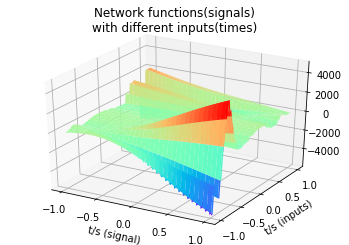

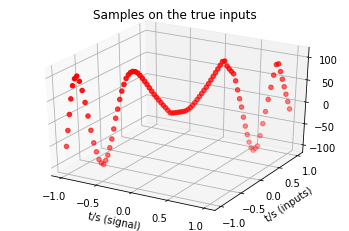

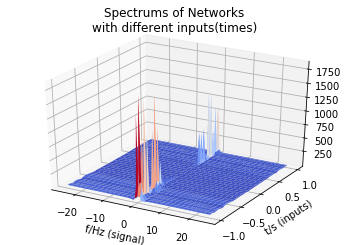

In [24]:
# 对多层网络进行处理观察实验结果
###############################################################
# 初始化时刻标签以方便绘图
time = [-1, -0.5, 0, 0.5, 1]
f = np.array([tick / 2 for tick in range(-fs, fs + 1)])
# 用以存放不同时刻，第二、三隐藏层线性近似后网络的输出信号
signal_r = np.zeros((N, N))
# 用以存放不同时刻，第二、三隐藏层线性近似后网络的频谱
spectrum = np.zeros((N, N))
# 遍历不同时刻（输入）
for s in range(N):
    # 网络第一隐藏层参数不变
    variables_re = [variables[1]]
    bias_re = [bias[0]]
    # 为第二、三隐藏层于该时刻的线性近似筛选参数
    for tick in range(1, 3):
        loc = []
        # 现将所有参数传递过来
        variables_re.append(variables[tick + 1])
        bias_re.append(bias[tick])
        # 遍历隐层节点
        for i in range(N * 2):
            # 若该结点中间变量为0，则处于饱和区，记录位置
            if results[tick][s, i] == 0:
                loc.append(i)
        # 倒置位置列表
        loc.reverse()
        # 从后往前删除失活节点对应的前、后权重以及对应的偏置
        for i in loc:
            # 节点前权重
            variables_re[-2] = np.delete(variables_re[-2], i, 1)
            # 偏置
            bias_re[-2] = np.delete(bias_re[-2], i, 1)
            # 节点后权重
            variables_re[-1] = np.delete(variables_re[-1], i, 0)
    # 将记录偏置更改到网络能够识别的形式
    bias_re[0] = bias_re[0].reshape((np.shape(bias_re[0])[1], ))
    bias_re[1] = bias_re[1].reshape((np.shape(bias_re[1])[1], ))
    bias_re[2] = bias_re[2].reshape((np.shape(bias_re[2])[1], ))
    # 构建网络并传递修改后的参数
    inputs = tf.keras.Input(shape = (1, ))
    # 第一层与裁剪前的网络一致
    Dense_1 = tf.keras.layers.Dense(units = np.shape(variables[0])[1], activation = tf.function(ReLU_apart), use_bias = False, kernel_initializer = tf.constant_initializer(variables[0]))(inputs)
    # 第二层运用裁剪后的参数做线性激活
    Dense_2 = tf.keras.layers.Dense(units = np.shape(variables_re[0])[1], activation = 'linear', kernel_initializer = tf.constant_initializer(variables_re[0]), bias_initializer = tf.constant_initializer(bias_re[0]))(Dense_1)
    # 第三层运用裁剪后的参数做线性激活
    Dense_3 = tf.keras.layers.Dense(units = np.shape(variables_re[1])[1], activation = 'linear', kernel_initializer = tf.constant_initializer(variables_re[1]), bias_initializer = tf.constant_initializer(bias_re[1]))(Dense_2)
    outputs = tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(variables_re[2]), bias_initializer = tf.constant_initializer(bias_re[2]))(Dense_3)
    model_tem = tf.keras.Model(inputs = inputs, outputs = outputs)
    # 记录该时刻近似的网络函数
    signal_r[s, : ] = model_tem.predict(t).reshape(N)
    del model_tem
    # 计算该时刻近似网络函数的频谱
    spectrum[s, : ] = np.fft.fft(signal_r[s, : ]) / N
    spectrum[s, : ] = np.fft.fftshift(spectrum[s, : ])

x_grid, y_grid = np.meshgrid(t, t)
# 绘制不同时刻网络函数变化图
fig = plt.figure()
data_3d = plt.axes(projection = '3d')
surface = data_3d.plot_surface(x_grid, y_grid, signal_r, cmap = 'rainbow')
z = np.array([signal_r[i, i] for i in range(N)])
plt.title('Network functions(signals)\nwith different inputs(times)')
data_3d.set_xlabel('t/s (signal)')
data_3d.set_ylabel('t/s (inputs)')
data_3d.set_xticks(time)
data_3d.set_yticks(time)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Multilayer_selection.tiff')
png.close()

#将不同时刻对应的原网络真值采样绘制
fig = plt.figure()
data_3d = plt.axes(projection = '3d')
data_3d.scatter(t, t, z, c = 'r')
plt.title('Samples on the true inputs')
data_3d.set_xlabel('t/s (signal)')
data_3d.set_ylabel('t/s (inputs)')
data_3d.set_xticks(time)
data_3d.set_yticks(time)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Multilayer_sampling.tiff')
png.close()

#绘制不同时刻网络函数频谱
fx_grid, fy_grid = np.meshgrid(f, f)
fig = plt.figure()
spec_3d = plt.axes(projection = '3d')
surface = spec_3d.plot_surface(fx_grid, y_grid, abs(spectrum), cmap = plt.cm.coolwarm)
plt.title('Spectrums of Networks\nwith different inputs(times)')
spec_3d.set_xlabel('f/Hz (signal)')
spec_3d.set_ylabel('t/s (inputs)')
spec_3d.set_yticks(time)
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Multilayer_spectrum.tiff')
png.close()

del variables, bias, variables_re, bias_re, signal_r, spectrum


In [25]:
# 给出考虑输入层偏置存在时，需要修订的模块
###############################################################
# 计算在偏置项影响下等价的级数系数
def Coefficient_bias(w0, wb):
    # 初始化存放系数的数组
    C = np.zeros(2 * order + 1, dtype = complex)
    B = np.zeros(order + 1)
    D = np.zeros(order + 1)
    # 依阶次遍历
    for cx in range(order + 1):
        # 计算偏置项等效角度
        angle = w0 * wb * cx
        # 计算复指数偏置项等价的实部和虚部
        cos = math.cos(angle)
        sin = math.sin(angle)
        # 修正余弦系数和正弦系数
        B[cx] = (Bk[cx].numpy() * cos - Dk[cx].numpy() * sin)
        D[cx] = (Bk[cx].numpy() * sin + Dk[cx].numpy() * cos)
        # 通过三角系数计算复指数级数系数
        C[cx] += B[cx] + D[cx] * 1j
        C[-cx] += B[cx] - D[cx] * 1j
    return C, B, D

# 将网络解码为频谱信息并预测网络输出，此时考虑输入存在偏置项时对频谱的影响
def decoder_b(t, direction, amplifier, bias, w0, wb):
    # 统计参数组数量
    num = np.shape(amplifier)[0]
    # 统计输入数据数
    N = np.shape(t)[0]
    # 初始化预测列表
    signal = np.zeros(N)
    # 循环为每个输入数据预测输出值
    for tick in range(N):
        # 循环计算每组网络参数对输出的贡献
        for cx in range(num):
            # 提取方向权重并计算三角级数频率量单位
            direct = direction[0, cx] * w0 * t[tick]
            # 提取放大权重值
            amplify = amplifier[cx, 0]
            # 初始化该组参数影响
            interval = 0
            # 重新计算在偏置项影响下等价的级数系数
            Ck_b, Bk_b, Dk_b = Coefficient_bias(w0, wb[cx])
            # 按阶次循环计算每阶分量的影响
            for ax in range(1, order + 1):
                # 计算对应阶次频率量
                w = direct * ax
                # 添加对应阶次影响，包含偏置项
                interval += (Bk_b[ax] * math.cos(w) - Dk_b[ax] * math.sin(w)) * 2
            # 添加对应参数组直流量影响
            interval += Ck_b[0]
            # 对该参数组影响进行放大
            interval *= amplify
            # 将该参数组的影响添加到对应输入数据的输出预测中
            signal[tick] += interval
        # 添加直流分量的影响
        signal[tick] += bias[0]
    return signal

# 将网络参数解码为频谱
def decoder_b_spec(direction, amplifier, bias, w0, wb):
    # 初始化存放频谱信息的字典
    spec = {}
    # 初始化直流分量为0
    spec[0] = 0
    # 统计参数组数量
    num = np.shape(amplifier)[0]
    # 依每个节点依次绘制频谱信息
    for i in range(num):
        # 重新计算在偏置项影响下等价的级数系数
        Ck_b, Bk_b, Dk_b = Coefficient_bias(w0, wb[i])
        # 叠加直流,包含偏置影响
        spec[0] += Ck_b[0] * amplifier[i, 0]
        # 依阶次叠加交流
        for j in range(1, order + 1):
            # 计算绘制谱线的位置
            loc = direction[0, i] * w0 * j
            # 叠加正方向频谱,包含偏置影响
            spec[loc] = spec.get(loc, 0) + Ck_b[j] * amplifier[i, 0]
            # 叠加负方向频谱,包含偏置影响
            spec[-loc] = spec.get(-loc, 0) + Ck_b[-j] * amplifier[i, 0]
    # 叠加偏置量到直流
    spec[0] += bias[0]
    return spec


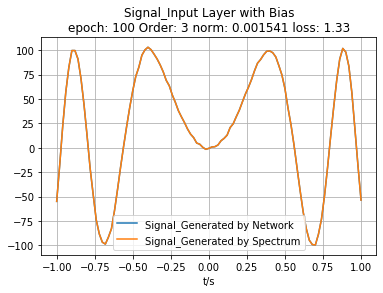

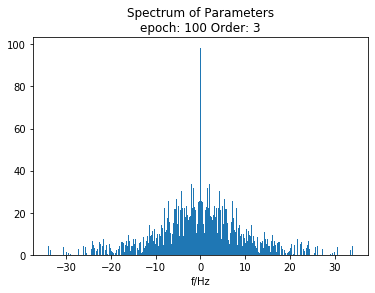

In [26]:
# 考虑输入层偏置存在时重建函数与网络函数一致性
###############################################################
# 构建网络
model_analysis = tf.keras.models.Sequential()
model_analysis.add(tf.keras.layers.InputLayer(input_shape = 1))
# 网络权重初始化的方差是参考信号频谱给出的，由于频域范围是25，于是为了保证方向权重能触及该频率上限于是定为标准差20
# 由此前的实现知，理想情况下网络隐藏层节点应不小于N-1，考虑到大多数网络节点数都远大于需求于是定为4N
model_analysis.add(tf.keras.layers.Dense(units = N * 4, activation = tf.function(ReLU_apart), kernel_initializer = tf.constant_initializer(np.random.normal(0, 20, [1, N * 4]))))
# 超参数选取策略同上
model_analysis.add(tf.keras.layers.Dense(units = 1, activation = 'linear', kernel_initializer = tf.constant_initializer(np.random.normal(0, 20, [N * 4, 1])), bias_initializer = tf.constant_initializer(np.random.normal(0, 20, [1, ]))))
# 规定学习率为1，是考虑到参数量级，同时也是经过多次实验得到的经验值
model_analysis.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1), loss = 'mean_squared_error', metrics = ['mean_squared_error'])
model_analysis.fit(x = t, y = signal, batch_size = N, epochs = 100, verbose = 0)

# 提取参数
variables = []
bias = []
tick = 0
for variable in model_analysis.trainable_variables:
    if tick % 2 == 0:
        variables.append(variable.numpy())
    else:
        bias.append(variable.numpy())
    tick += 1

# 预测网络输出
signal_net = model_analysis.predict(t)
# 用解码器通过频谱还原网络输出
signal_rebuild = decoder_b(t, variables[0], variables[1], bias[1], w0, bias[0])
# 绘制此时网络参数对应的频谱信息
signal_spec = decoder_b_spec(variables[0], variables[1], bias[1], w0, bias[0])
# 计算最大值范数
sub = []
for i, value in enumerate(signal_net):
    sub.append(abs(value - signal_rebuild[i]))
sub = max(sub)
# 计算损失
loss, mse = model_analysis.evaluate(x = t, y = signal, verbose = 0)

# 绘制预测值曲线
plt.figure()
plt.plot(t, signal_net, label = 'Signal_Generated by Network')
plt.plot(t, signal_rebuild, label = 'Signal_Generated by Spectrum')
plt.grid()
plt.legend()
plt.title('Signal_Input Layer with Bias\nepoch: %d Order: %d norm: %f loss: %.2f'%(cx, order, sub, loss))
plt.xlabel('t/s')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Signal_NetworkRebuild_1D_Bias.tiff')
png.close()

# 绘制网络参数对应频谱
f = list(signal_spec.keys())
for i, value in enumerate(f):
    f[i] = value / math.pi / 2
spec = list(signal_spec.values())
for i, value in enumerate(spec):
    spec[i] = abs(value)
plt.figure()
plt.bar(f, spec, width = 0.2)
plt.title('Spectrum of Parameters\nepoch: %d Order: %d'%(cx, order))
plt.xlabel('f/Hz')
png = io.BytesIO()
plt.savefig(png, format = 'png', dpi = 500, pad_inches = .1, bbox_inches = 'tight')
tiff = Image.open(png)
tiff.save('Spectrum_Network_1D_Bias.tiff')
png.close()
